In [8]:
from pathlib import Path

DST_ROOT = Path("data")
IN_DIR  = DST_ROOT / "Input"
GT_DIR  = DST_ROOT / "GT"
MSK_DIR = DST_ROOT / "Mask"

n_in  = len(list(IN_DIR.glob("*.png")))
n_gt  = len(list(GT_DIR.glob("*.png")))
n_msk = len(list(MSK_DIR.glob("*.png")))

print("Counts")
print(" Input:", n_in)
print(" GT   :", n_gt)
print(" Mask :", n_msk)



Counts
 Input: 300
 GT   : 300
 Mask : 300


In [11]:
from pathlib import Path
import numpy as np
import cv2

GT_DIR = Path(r"C:\Users\dltlg\OneDrive\Desktop\workshop\data\GT")
OUT_ROOT = GT_DIR.parent / "Noisy"

SEED = 42
rng = np.random.default_rng(SEED)

def poisson_gaussian_u8(img_u8, peak=30, sigma=10, rng=None):
    """
    img_u8: uint8 (0~255)
    peak: Poisson strength (낮을수록 Poisson noise 큼)
    sigma: Gaussian std in 'pixel intensity scale' (0~255 기준)
    """
    if rng is None:
        rng = np.random.default_rng()

    x = img_u8.astype(np.float32) / 255.0                 # 0~1
    lam = np.clip(x * float(peak), 0.0, None)             # 기대값
    y_p = rng.poisson(lam).astype(np.float32) / float(peak)  # 0~1

    y = y_p + rng.normal(0.0, sigma / 255.0, size=y_p.shape).astype(np.float32)
    y = np.clip(y, 0.0, 1.0)
    return (y * 255.0 + 0.5).astype(np.uint8)

# ===== 원하는 노이즈 셋 =====
configs = [
    ("pg_peak30_sigma10", dict(peak=30, sigma=10)),
    ("pg_peak30_sigma25", dict(peak=30, sigma=25)),
    # 더 다양하게 하고 싶으면 아래처럼 추가:
    # ("pg_peak60_sigma10", dict(peak=60, sigma=10)),
]

pngs = sorted(GT_DIR.glob("*.png"))
print("GT count:", len(pngs))

for name, cfg in configs:
    out_dir = OUT_ROOT / name
    out_dir.mkdir(parents=True, exist_ok=True)

    for i, p in enumerate(pngs, 1):
        im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if im is None:
            print("[WARN] read fail:", p)
            continue

        noisy = poisson_gaussian_u8(im, **cfg, rng=rng)
        cv2.imwrite(str(out_dir / p.name), noisy)

        if i % 200 == 0:
            print(f"{name}: {i}/{len(pngs)} saved...")

print("DONE ->", OUT_ROOT)


GT count: 300
pg_peak30_sigma10: 200/300 saved...
pg_peak30_sigma25: 200/300 saved...
DONE -> C:\Users\dltlg\OneDrive\Desktop\workshop\data\Noisy


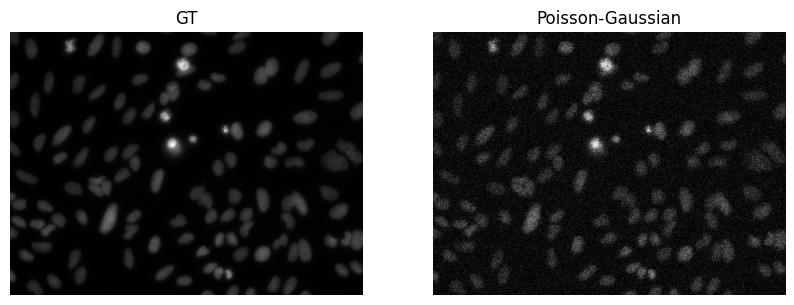

GT  min/max: 0 255
NZ  min/max: 0 255
diff mean/std: 133.64511217948717 114.43259190120676


In [12]:
import random, numpy as np, cv2, matplotlib.pyplot as plt
from pathlib import Path

GT_DIR = Path(r"C:\Users\dltlg\OneDrive\Desktop\workshop\data\GT")
NOISY_DIR = GT_DIR.parent / "Noisy" / "pg_peak30_sigma25"

files = sorted(GT_DIR.glob("*.png"))
p = random.choice(files)

gt = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
nz = cv2.imread(str(NOISY_DIR / p.name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("GT"); plt.imshow(gt, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Poisson-Gaussian"); plt.imshow(nz, cmap="gray"); plt.axis("off")
plt.show()

print("GT  min/max:", gt.min(), gt.max())
print("NZ  min/max:", nz.min(), nz.max())
print("diff mean/std:", float((nz-gt).mean()), float((nz-gt).std()))
